In [1]:
cd ../../../

/private/home/ronghanghu/workspace/mmf_nr


In [2]:
import os
import numpy as np
import skimage.io
import cv2
import torch
import torchvision
import argparse
import omegaconf
import matplotlib.pyplot as plt
import quaternion

from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration
from mmf.utils.build import build_config, build_model
from mmf.common.sample import SampleList, Sample


def get_config_from_opts(opts):
    setup_imports()

    args = argparse.Namespace(config_override=None)
    args.opts = opts

    configuration = Configuration(args)
    config = build_config(configuration)
    return config


def load_model(config, device, ckpt_file=None):
    attributes = config.model_config[config.model]
    # Easy way to point to config for other model
    if isinstance(attributes, str):
        attributes = config.model_config[attributes]

    with omegaconf.open_dict(attributes):
        attributes.model = config.model

    model = build_model(attributes)
    model = model.to(device)
    model.eval()

    if ckpt_file is not None:
        state_dict = torch.load(ckpt_file, map_location=device)["model"]
        model.load_state_dict(state_dict)

    return model


def build_sample_list(img_0, R_0, T_0, R_1, T_1, image_transform):
    sample = Sample()
    sample.orig_img_0 = torch.tensor(img_0)
    sample.trans_img_0 = image_transform(sample.orig_img_0.permute((2, 0, 1)))
    sample.R_0 = torch.tensor(R_0)
    sample.T_0 = torch.tensor(T_0)
    sample.R_1 = torch.tensor(R_1)
    sample.T_1 = torch.tensor(T_1)
    sample_list = SampleList([sample]).to(device)
    return sample_list

In [3]:
def get_habitat_position_rotation(R, T):
    P = np.eye(4, dtype=np.float32)
    P[0:3, 0:3] = R.T
    P[0:3, 3] = T
    
    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis
    
    Pinv = np.linalg.inv(P)
    position = Pinv[0:3, 3]
    rotation = Pinv[0:3, 0:3]
    rotation = quaternion.from_rotation_matrix(rotation)
    
    return position, rotation

    
def get_pytorch3d_camera_RT(position, rotation):
    rotation = quaternion.as_rotation_matrix(rotation)

    Pinv = np.eye(4, dtype=np.float32)
    Pinv[0:3, 0:3] = rotation
    Pinv[0:3, 3] = position
    P = np.linalg.inv(Pinv)

    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis

    R = P[0:3, 0:3].T  # to row major
    T = P[0:3, 3]

    return R, T

In [4]:
np.linspace(np.zeros(3), np.ones(3), 20).shape

(20, 3)

In [5]:
def interpolate_angle(angle_a, angle_b, num):
    diff = angle_b - angle_a

    # now diff in [0, 2*pi]
    diff = diff - 2*np.pi * np.floor(diff / (2*np.pi))

    # now abs(diff) <= np.pi
    diff = diff - 2*np.pi * np.floor(diff / np.pi)

    return np.linspace(angle_a, angle_a + diff, num)


def interpolate_rotation_quaternion(rotation_a, rotation_b, num):
    euler_angle_a = quaternion.as_euler_angles(rotation_a)
    euler_angle_b = quaternion.as_euler_angles(rotation_b)
    interpolated_euler_angles = interpolate_angle(euler_angle_a, euler_angle_b, num)
    interpolated_rotations = [quaternion.from_euler_angles(e) for e in interpolated_euler_angles]

    return interpolated_rotations


def interpolate_RT_matrix(R_a, T_a, R_b, T_b, num):
    position_a, rotation_a = get_habitat_position_rotation(R_a, T_a)
    position_b, rotation_b = get_habitat_position_rotation(R_b, T_b)
    
    positions = np.linspace(position_a, position_b, num)
    rotations = interpolate_rotation_quaternion(rotation_a, rotation_b, num)
    
    Rs, Ts = zip(*(get_pytorch3d_camera_RT(p, r) for p, r in zip(positions, rotations)))
    return Rs, Ts

In [6]:
exp_name = "defaults"

opts = [
    f"config=projects/neural_rendering/configs/replica/{exp_name}.yaml",
    f"datasets=replica",
    f"model=mesh_renderer",
    f"training.batch_size=1",
    f"model_config.mesh_renderer.return_rendering_results_only=True",
]

device = torch.device("cuda:1")
torch.cuda.set_device(device)

ckpt_file = f"./save/replica/{exp_name}/best.ckpt"
if not os.path.exists(ckpt_file):
    ckpt_file = ckpt_file.replace("best.ckpt", "current.ckpt")
assert os.path.exists(ckpt_file)

config = get_config_from_opts(opts)
model = load_model(config, device, ckpt_file)

/private/home/ronghanghu/workspace/mmf_nr/mmf/models/base_model.py:96: UserWarning: No losses are defined in model configuration. You are expected to return loss in your return dict from forward.
  "No losses are defined in model configuration. You are expected "


In [7]:
saved_data_file = "/checkpoint/ronghanghu/neural_rendering_datasets/replica/test/data/scene_0000_sample_00000000.npz"
saved_results_file = './save/visualization/defaults/test/scene_0000_sample_00000000_outputs.npz'

d = np.load(saved_data_file)
data = dict(d)
d.close()
d = np.load(saved_results_file)
data.update(d)
d.close()

# normalize with ResNet-50 preprocessing
image_transform = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


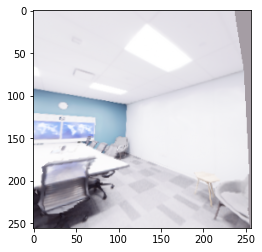

In [8]:
sample_list = build_sample_list(
    img_0=data['orig_img_0'],
    R_0=data["camera_Rs"][0],
    T_0=data["camera_Ts"][0],
    R_1=data["camera_Rs"][1],
    T_1=data["camera_Ts"][1],
    image_transform=image_transform
).to(device)

with torch.no_grad():
    rendering_results = model.forward(sample_list)

rgba_out = rendering_results['rgba_out_rec_list'][1][0, ..., :3].cpu().numpy()
plt.imshow(rgba_out)

In [9]:
Rs, Ts = interpolate_RT_matrix(
    R_a=data["camera_Rs"][0],
    T_a=data["camera_Ts"][0],
    R_b=data["camera_Rs"][1],
    T_b=data["camera_Ts"][1],
    num=120
)

In [10]:
frames = []
for r, t in zip(Rs, Ts):
    sample_list = build_sample_list(
        img_0=data['orig_img_0'],
        R_0=data["camera_Rs"][0],
        T_0=data["camera_Ts"][0],
        R_1=r,
        T_1=t,
        image_transform=image_transform
    ).to(device)

    with torch.no_grad():
        rendering_results = model.forward(sample_list)

    rgba_out = rendering_results['rgba_out_rec_list'][1][0, ..., :3].cpu().numpy()
    rgba_out = np.clip(rgba_out, 0, 1)

    # float32 -> uint8, RGB -> BGR
    frames.append(skimage.img_as_ubyte(rgba_out[..., ::-1]))

In [11]:
video_file = "/private/home/ronghanghu/workspace/camera_RT_interpolation.mp4"
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
fps = 30
frame_size = (256, 256)
writer = cv2.VideoWriter(video_file, fourcc, fps, frame_size)

for img in frames:
    writer.write(img)
writer.release()